# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [23]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline


import Helper as h

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [24]:
# load in the data
df_azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
df_customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [25]:
df_customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4


In [26]:
df_customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [27]:
df_azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [28]:
df_azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


Renaming the column names to understandble form.

In [29]:
# Drop the extra column of customers dataset.
df_customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

Perform Data cleaning and preprocessing steps

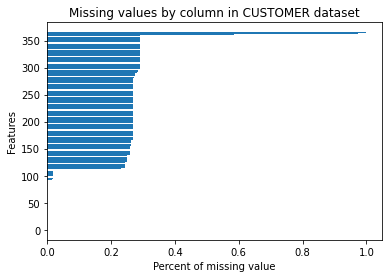

In [30]:
#Customer columns with missing values
plt.barh(np.arange(len(df_customers.columns)), df_customers.isnull().mean().sort_values(ascending=True))
plt.xlabel('Percent of missing value')
plt.ylabel('Features')
plt.title('Missing values by column in CUSTOMER dataset')
#plt.savefig('missing_customer', quality = 100)
plt.show()

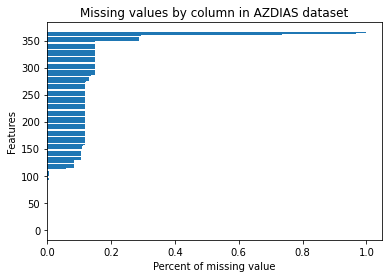

In [31]:
#azdias columns with missing values
plt.barh(np.arange(len(df_azdias.columns)), df_azdias.isnull().mean().sort_values(ascending=True))
plt.xlabel('Percent of missing value')
plt.ylabel('Features')
plt.title('Missing values by column in AZDIAS dataset')
#plt.savefig('missing_azdias', quality = 100)
plt.show()

As we can see we have some types which have very high percentage of Null values

In [32]:
#columns with more than 30% missing values
df_customers.columns[df_customers.isna().mean() > 0.3]

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [33]:
#columns with more than 30% missing values
df_azdias.columns[df_azdias.isna().mean() > 0.3]

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

Let's preprocess the data. The function in our helper class handles missing values, converts data formats.

In [34]:
df_customers = h.data_pre_process(df_customers)
df_azdias = h.data_pre_process(df_azdias)

In [35]:
df_customers.columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB',
       'YEAR_ADDED'],
      dtype='object', length=365)

In [36]:
#renaming major columns for better understanbility
df_azdias = df_azdias.rename(columns=h.column_transform_dict)
df_customers = df_customers.rename(columns=h.column_transform_dict)

In [37]:
scaling = StandardScaler()

In [38]:
df_customers_scaled = scaling.fit_transform(df_customers)
df_azdias_scaled = scaling.fit_transform(df_azdias)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### We will use PCA and K-means for our Unsupervised analysis of data.

#### PCA  <br>
PCA is used to reduce the dimension of the data with minimum loss of information. As we have around 360 columns in our dataset, it will be easier to perform unsupervised analysis on reduced dimensions. 

In [39]:
from sklearn.decomposition import PCA
pca = PCA(random_state=123)

In [40]:
customer_pca = pca.fit_transform(df_customers_scaled)

In [41]:
# Number of components required to maintain %80 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1)
n_components

116

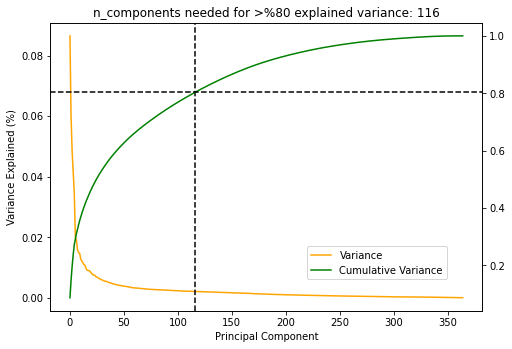

In [42]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1],True)
ax2 = ax1.twinx()
ax1.plot(pca.explained_variance_ratio_, label='Variance', color = 'orange')
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'Green');
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Variance Explained (%)")
ax1.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax1.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2))
#plt.savefig('PCA', quality = 100)

Top 5 important features for component 1

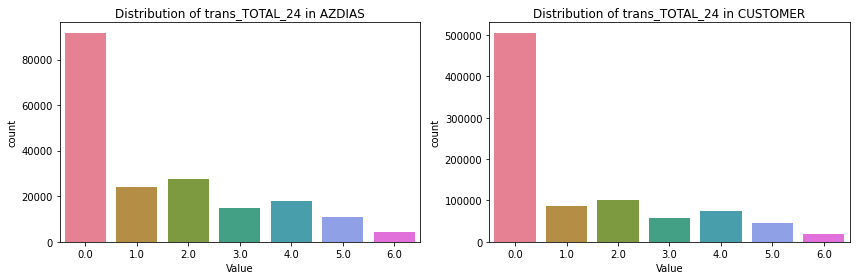

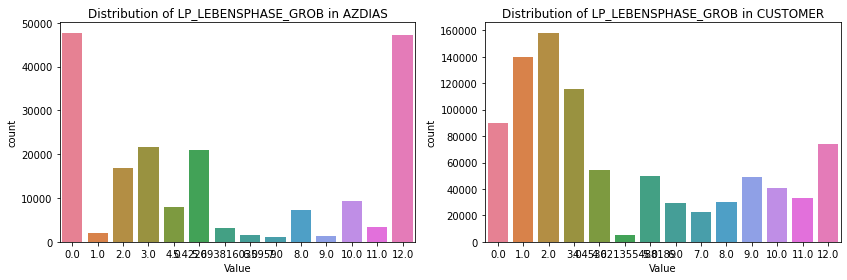

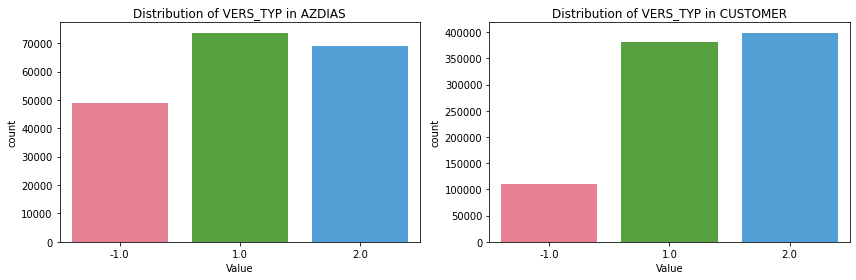

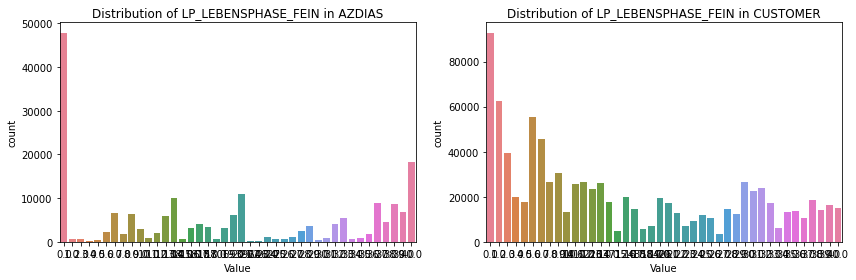

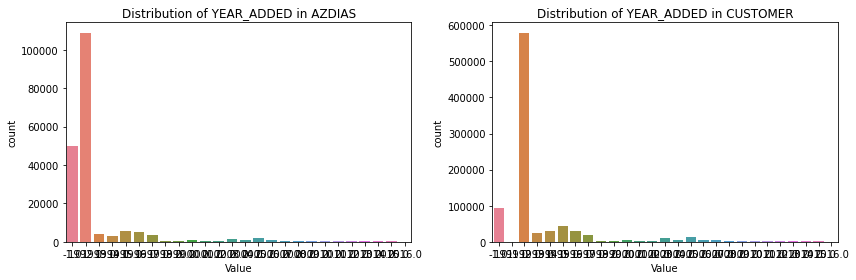

In [44]:
df = pd.DataFrame(sorted(zip(df_customers.columns, pca.components_[0]), key=lambda x: x[1])[-5:],
            columns=['feature','coef'])
for column in (df['feature'].values):
    h.plot_comparison_charts(column,df_customers,df_azdias)

Top 5 important features for component 1 with least coef

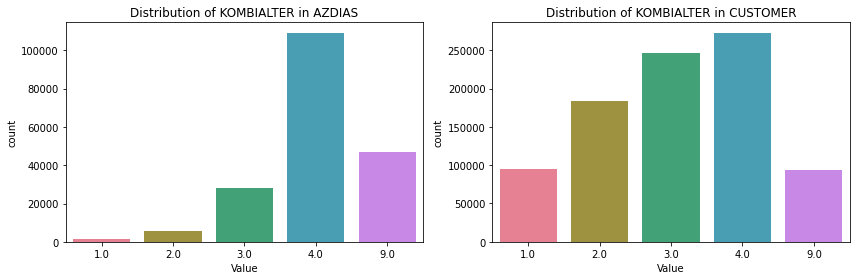

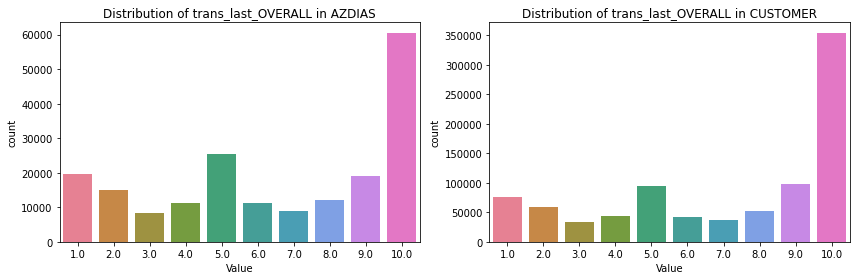

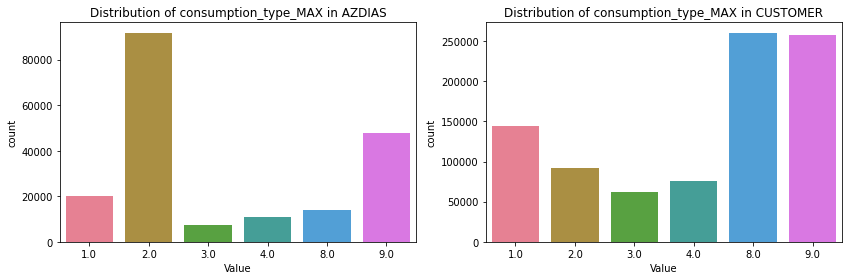

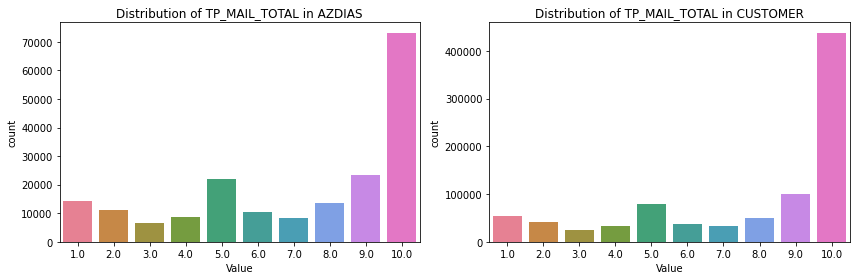

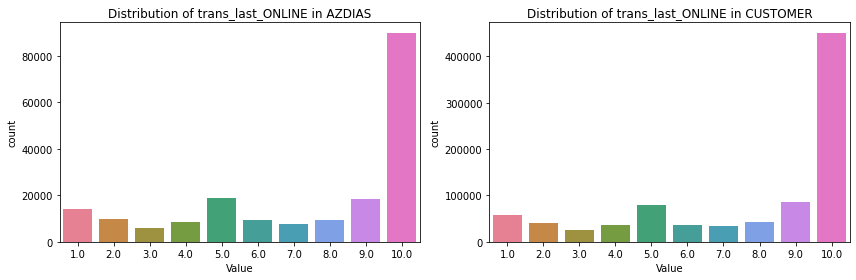

In [45]:
df = pd.DataFrame(sorted(zip(df_customers.columns, pca.components_[0]), key=lambda x: x[1])[:5],
            columns=['feature','coef'])
for column in (df['feature'].values):
    h.plot_comparison_charts(column,df_customers,df_azdias)

Top 5 important features for component 2

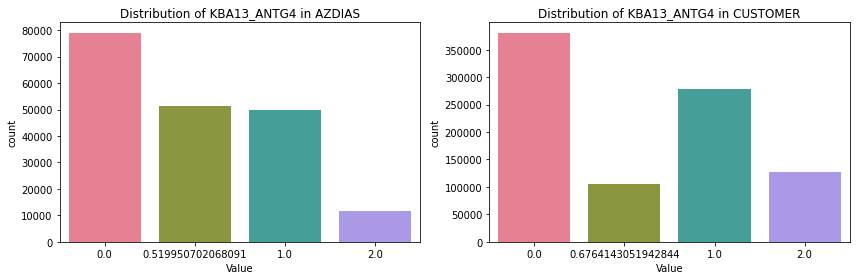

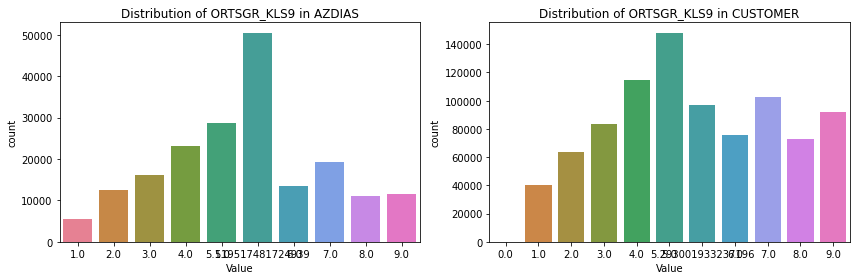

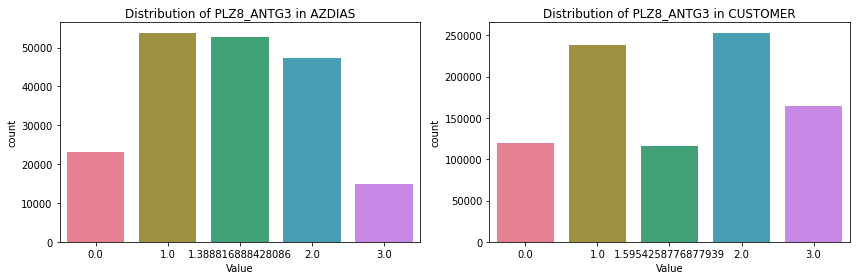

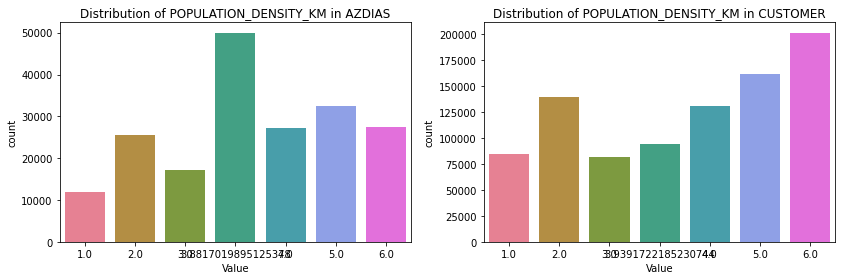

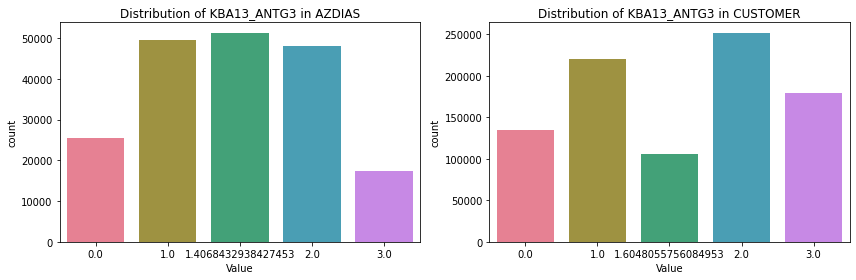

In [46]:
df = pd.DataFrame(sorted(zip(df_customers.columns, pca.components_[1]), key=lambda x: x[1])[-5:],
            columns=['feature','coef'])
for column in (df['feature'].values):
    h.plot_comparison_charts(column,df_customers,df_azdias)

Top 5 important features for component 2 with least coef

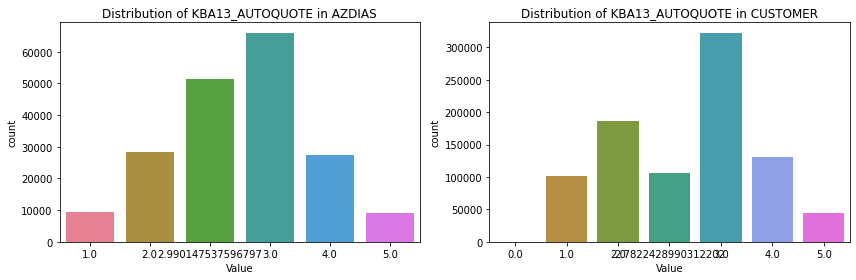

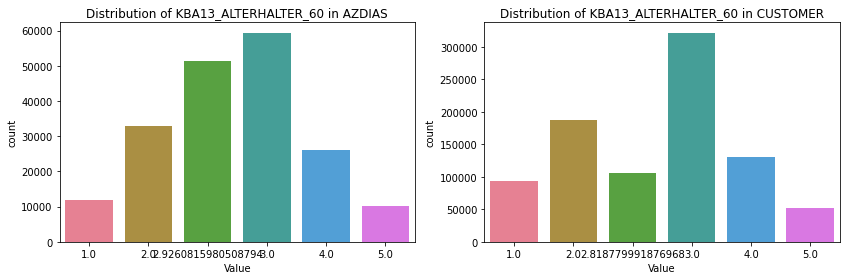

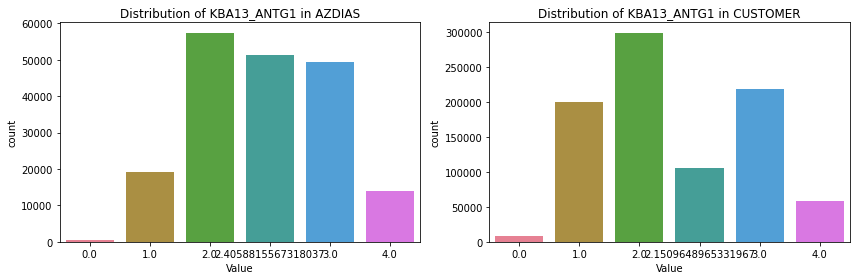

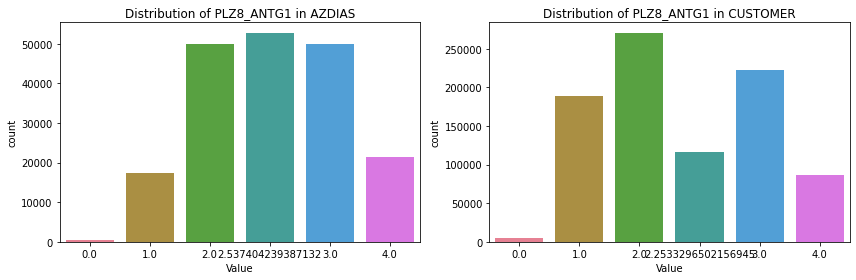

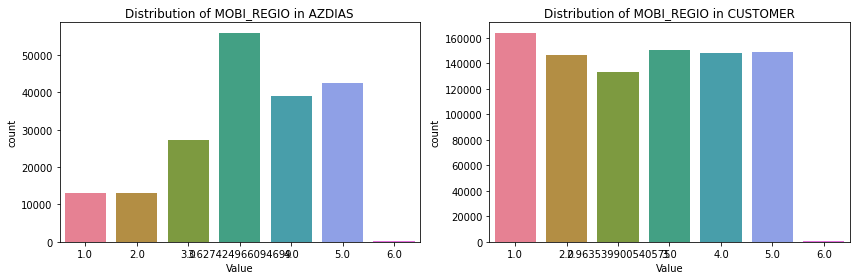

In [47]:
df = pd.DataFrame(sorted(zip(df_customers.columns, pca.components_[1]), key=lambda x: x[1])[:5],
            columns=['feature','coef'])
for column in (df['feature'].values):
    h.plot_comparison_charts(column,df_customers,df_azdias)

Apply PCA to transform CUSTOMER and AZDIAS dataframes

In [48]:
df_customers_pca = pca.transform(df_customers_scaled)

In [49]:
df_azdias_pca = pca.transform(df_azdias_scaled)

#### K-Means
Define clusters of customers to identify their behaviour 

   centroids         score
0         30  2.104340e+06
1         25  2.291471e+06
2         22  2.442962e+06
3         20  2.560410e+06
4         15  2.976282e+06
5         11  3.537861e+06
6         10  3.769443e+06
7          5  6.467182e+06
8          2  1.393745e+07


Text(0, 0.5, 'Sum of Squared Errors')

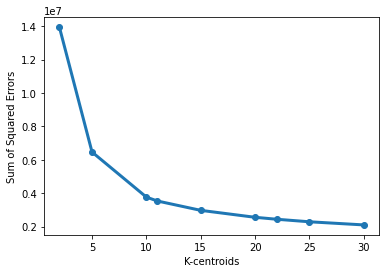

In [50]:
# Function to calculate K-Means score for a centroid
def elbow_method(data, center):
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

# Run possible number of cluster centroid through K-means score function
score_pca = []
centroids = [2,5,10,11,15,20,22,25,30]

for x in centroids:
    score_pca.append(elbow_method(df_customers_pca[:,:5],x))
    
# print score report
print(pd.DataFrame(sorted(zip(centroids, score_pca), key=lambda x: x[1]),
            columns=['centroids','score']))

plt.plot(centroids,score_pca,linestyle='-',linewidth=3,marker='o')
plt.xlabel('K-centroids')
plt.ylabel('Sum of Squared Errors')

In the plot above the error rate is decreasing less gradually after 10 clusters. As a result, we choose 10 as our final cluster number.

In [ ]:
kmeans = KMeans(10, random_state=123)
clusters_pop = kmeans.fit_predict(df_azdias_pca)
clusters_cust = kmeans.predict(df_customers_pca)

In [52]:
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 10,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': 123,
 'tol': 0.0001,
 'verbose': 0}

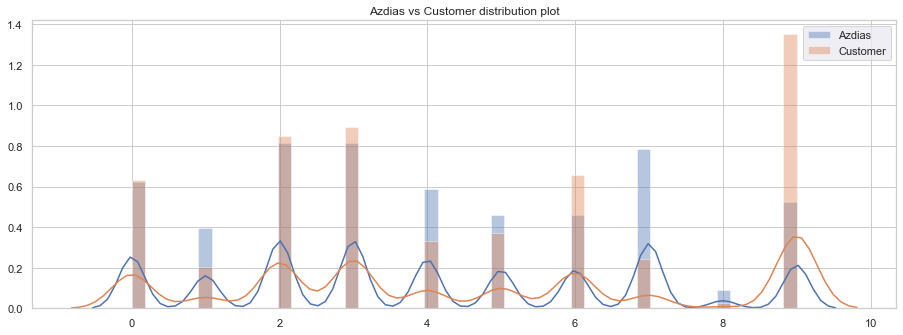

In [79]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Azdias vs Customer distribution plot')
sns.set(style="darkgrid")
sns.distplot(clusters_pop, label='Azdias',ax=ax)
sns.distplot(clusters_cust, label='Customer', ax=ax)
ax.legend()
#plt.savefig('k_dist', quality = 100)

Based on cluster distribution histogram on both datasets, it is clear to see that Cluster 9 is outstanding for customers, which means people in this group is more likely to be part of the mail-order company’s main customer base than other groups.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
df_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [4]:
df_train_clean = h.data_pre_process_test(df_train)

In [5]:
X_train = df_train_clean.iloc[:,df_train_clean.columns != 'RESPONSE']
y_train = df_train_clean['RESPONSE']

In [6]:
scaler_model = StandardScaler()
X_train = scaler_model.fit_transform(X_train)

Text(0.5, 1.0, 'Distribution of REPSONSE variable')

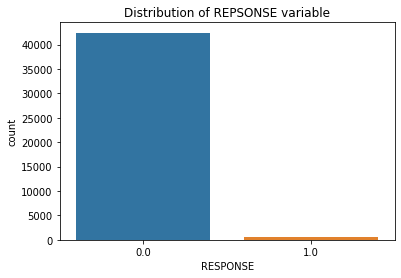

In [7]:
sns.countplot(y_train).set_title('Distribution of REPSONSE variable')

It is clear from the above figure that the data is highly imbalanced.

In [8]:
# LogisticRegression
lor = LogisticRegression(random_state=123)
h.classifier_GS(lor, {}, X_train, y_train)

0.6604681258910036


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=123)
h.classifier_GS(rfc, {}, X_train, y_train)

In [9]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=123)
gbc = h.classifier_GS(gbc, {}, X_train, y_train)
gbc

0.7564488813568817


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#catboost classifier
catboost = CatBoostClassifier(random_state=123, silent=True)
h.classifier_GS(catboost,{}, X_train, y_train)

In [20]:
# tune the most promising classifier with the help of GridSearchCV
# the result is our model that will be used with the test set
cbc = CatBoostClassifier(random_state=123, silent=True)
param_grid = {'depth' : [2,3],
              'border_count': [3,5],
              'l2_leaf_reg':[1,3]
             }

cbc_best_est = h.classifier_GS(cbc, param_grid, X_train, y_train)
cbc_best_est

cbc_best_est.get_params()

0.7702320870126916


{'depth': 2,
 'l2_leaf_reg': 1,
 'border_count': 3,
 'silent': True,
 'random_state': 123}

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [10]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [11]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


Data preprocessing

In [12]:
test_ids = mailout_test.LNR

In [15]:
df_test_processed = h.data_pre_process_test(mailout_test)

In [16]:
df_test_processed = scaler_model.fit_transform(df_test_processed)

Classification

In [21]:
predict_prob = cbc_best_est.predict_proba(df_test_processed)
predict_prob

array([[0.95170983, 0.04829017],
       [0.9718091 , 0.0281909 ],
       [0.99720556, 0.00279444],
       ...,
       [0.98739398, 0.01260602],
       [0.98328971, 0.01671029],
       [0.98303055, 0.01696945]])

Generate output file for the Kaggle competition

In [22]:
# generate prediction file for the competition
result = pd.DataFrame({'LNR':test_ids, 'RESPONSE':predict_prob[:,1]})
result.to_csv(path_or_buf='./predictions2.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.048290
1,1770,0.028191
2,1465,0.002794
3,1470,0.002398
4,1478,0.000966
5,1782,0.002275
6,1485,0.002454
7,1519,0.025249
8,1835,0.020654
9,1522,0.004573
